# Lecture 13 - Boosting

# Boosting

**Boosting** (or **Hypothesis Boosting**) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are **AdaBoost** (short for **Adaptive Boosting**) and **Gradient Boosting**.

## AdaBoost (or Adaptive Boosting)

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training samples that the predecessor underfitted. This results in new predictors focusing more and more on the "difficult samples". This is the technique used by AdaBoost. 

For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. This sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor's parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

### Weight Assignment

Each sample weight $w^{(i)}$ is initially set to $1/N$ (where $N$ is the number of samples). A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set.

In general, the **weighted error rate of the $j$-th predictor** is:

\begin{align*}
r_j = \frac{\sum\limits_{\substack{i=1 \\ \hat{y}_j^{(i)}\neq y^{(i)}}}^N w^{(i)}}{\sum_{i=1}^N w^{(i)}}
\end{align*}

where $\hat{y}_j$ is the $j$-th predictor's prediction for the $i$-th sample. The numerator sums all samples' weights for which the prediction is incorrect. The denominator sums all samples' weights.

The **predictor's weight** $\alpha_j$ is then computed with

\begin{align*}
\alpha_j = \eta \log\frac{1-r_j}{r_j}
\end{align*}

where $\eta$ is the learning rate hyperparameter (defaults to 1). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

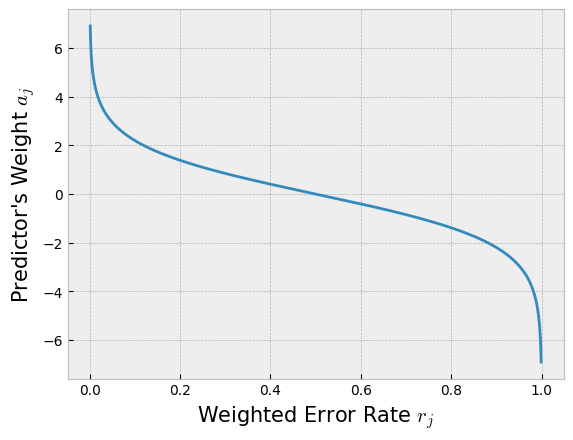

In [4]:
eta = 1
# np.linspace(start, stop, num)  -   NumPy function that generates a list of numbers evenly spaced between two endpoints. 
r = np.linspace(0.001,0.999,10_000) #0.001 - Very small error rate(perfect model) ;0.999-Very high error rate (almost always wrong); 10_000-This is just the number of points you want for smooth plotting. Not required by the formula.
a = eta*np.log((1-r)/r)

plt.plot(r,a)
plt.xlabel('Weighted Error Rate $r_j$',size=15)
plt.ylabel("Predictor's Weight $a_j$", size=15);

The more accurate the predictor is, the higher its weight $\alpha_j$ will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

Next, the AdaBoost algorithm updates the instance weights using the update equation:

\begin{align*}
w^{(i)} \longleftarrow \begin{cases} w^{(i)} & \text{if } \hat{y}_j^{(i)}=y^{(i)} \\ w^{(i)}\exp(\alpha_j) & \text{if } \hat{y}_j^{(i)}\neq y^{(i)} \end{cases}\text{, }\forall i=1,2,\dots, N
\end{align*}

which boosts the weights of the misclassified instances.

Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^N w^{(i)}$).

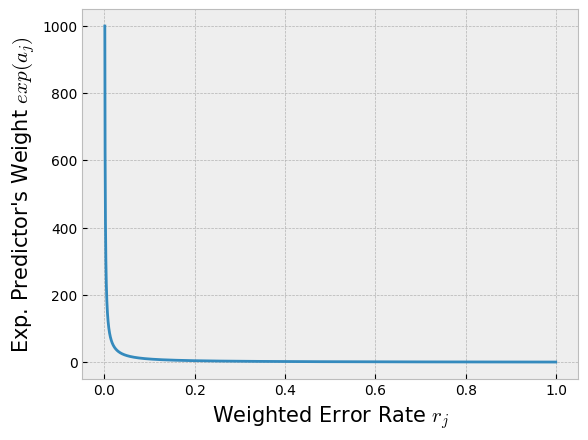

In [5]:
plt.plot(r,np.exp(a))
plt.xlabel('Weighted Error Rate $r_j$',size=15)
plt.ylabel("Exp. Predictor's Weight $exp(a_j)$", size=15);

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor's weight is computed, the instance weights are updated, then another predictor is trained, and so on). 

The **convergence criteria** includes: reaching the desired number of predictors or zero errors.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes:

\begin{align*}
\hat{y}(x) = \arg_k\max \sum\limits_{\substack{j=1 \\ \hat{y}_j(x)=k}}^M \alpha_j
\end{align*}

where $M$ is the number of predictors, and $k$ is the class label.

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Nice imports 🙂 These are all tools you’d typically use to *play with* ensemble methods like boosting/bagging and understand that α–vs–r graph in practice.

Let me tie each one to the concept:

---

### 1. `make_blobs`

* **What it does:** Creates a simple synthetic classification dataset (clusters in 2D or higher).
* **Why here:**
  You can generate an easy toy dataset to **visualize** how:

  * a weak learner (small tree) behaves,
  * an ensemble (AdaBoost / Bagging) improves decision boundaries.

---

### 2. `train_test_split`

* **What it does:** Splits data into train and test sets.
* **Why here:**
  Needed to:

  * train your weak learners / ensemble on the **training set**,
  * evaluate accuracy, error rate (r_j) on the **test set** (or a validation set),
    which is exactly the error that drives the weight formula
    (\alpha_j = \log\frac{1-r_j}{r_j}).

---

### 3. `DecisionTreeClassifier`

* **What it does:** Builds decision trees.
* **Why here (very important):**

  * In AdaBoost, the **base estimator** is often a **decision stump** (tree with max_depth=1).
  * Each stump has its own error rate (r_j), then we compute (\alpha_j) for it.
  * In Bagging, you also often bag full trees.

So this class is your **weak learner** in the ensemble.

---

### 4. `BaggingClassifier`

* **What it does:** Implements **bagging** (bootstrap aggregating) in sklearn.
* **Relation to the concept:**

  * It’s another ensemble method you can **compare** to boosting.
  * Bagging: many models trained independently on bootstrapped samples, then averaged/voted.
  * Boosting: models trained **sequentially**, with weights based on error (r_j) (your graph).

So Bagging is a good “neighbor concept” to understand how boosting is different.

---

### 5. `accuracy_score`

* **What it does:** Computes classification accuracy.
* **Why here:**

  * From predictions you get accuracy → 1 − accuracy ≈ error rate.
  * For a weighted setting, you can compute a **weighted error rate** (r_j) for each weak learner, which then goes into (\alpha_j = \log\frac{1-r_j}{r_j}).

So this is how you **measure performance / r_j** in experiments.

---

### 6. `StandardScaler`

* **What it does:** Standardizes features (zero mean, unit variance).
* **Why here:**

  * Not needed for trees, but **very important** for models like Logistic Regression.
  * Useful if you want to compare:

    * a simple linear model vs
    * non-linear ensembles (trees, bagging, boosting).

So it prepares data for models that are sensitive to feature scales.

---

### 7. `LogisticRegression`

* **What it does:** Linear classifier.
* **Why here:**

  * Often used as a **baseline** model: “How good is a single simple classifier compared to boosting/bagging?”
  * You can also (in theory) use it as a base estimator in some ensemble methods, though trees are more common.

So it gives you a **single-model reference** to compare against ensemble improvements.

---



In [7]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

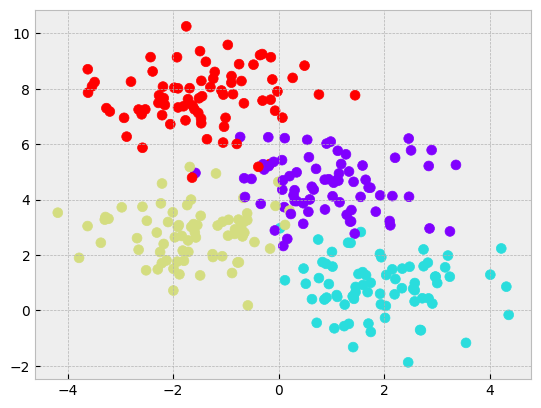

In [9]:
X, t = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

plt.scatter(X[:, 0], X[:, 1], c=t, s=50, cmap='rainbow');



In [10]:
X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                    stratify=t,
                                                   test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier?

Init signature:
AdaBoostClassifier(
    estimator=None,
    *,
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME.R',
    random_state=None,
)
Docstring:     
An AdaBoost classifier.

An AdaBoost [1]_ classifier is a meta-estimator that begins by fitting a
classifier on the original dataset and then fits additional copies of the
classifier on the same dataset but where the weights of incorrectly
classified instances are adjusted such that subsequent classifiers focus
more on difficult cases.

This class implements the algorithm based on [2]_.

Read more in the :ref:`User Guide <adaboost>`.

.. versionadded:: 0.14

Parameters
----------
estimator : object, default=None
    The base estimator from which the boosted ensemble is built.
    Support for sample weighting is required, as well as proper
    ``classes_`` and ``n_classes_`` attributes. If ``None``, then
    the base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`
    initialized with `max_depth=1`.

    .

```Scikit-Learn``` uses a multi-class version of AdaBoost called **SAMME** (which stands for **Stagewise Additive Modeling using a Multiclass Exponential** loss function). When there are just two classes, SAMME is equivalent to AdaBoost.

In [14]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3), 
    n_estimators=100,
    algorithm='SAMME',
    learning_rate=0.01) 

ada_clf.fit(X_train, t_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.01, n_estimators=100)

Train Accuracy: 0.9458333333333333
Test Accuracy: 0.9666666666666667


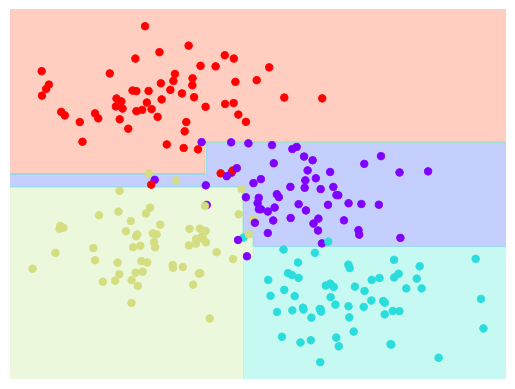

In [ ]:
visualize_classifier(ada_clf, X_train, t_train)

y_train = ada_clf.predict(X_train)
y_test = ada_clf.predict(X_test)
print('Train Accuracy:', 
      accuracy_score(t_train, y_train))
print('Test Accuracy:', 
      accuracy_score(t_test, y_test))

If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

---

# Gradient Boosting

Another very popular boosting algorithm is **Gradient Boosting**. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to **fit the new predictor to the residual errors made by the previous predictor**. 

Let's go through a simple regression example, using Decision Trees as the base predictors (of course, Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or **Gradient Boosted Regression Trees (or GBRT)**. First, let's fit a ```DecisionTreeRegressor``` to the training set (for example, a noisy quadratic training set):

Here is the **simplest possible explanation** of **Gradient Boosting** — clear, intuitive, and without unnecessary math.

---

# 🌟 **Gradient Boosting — Simple Definition**

**Gradient Boosting is an ensemble method where models are added one at a time, and each new model tries to correct the mistakes of the previous models by following the gradient of the loss function.**

In other words:

### 🔥 “Each new tree fixes the errors made by the previous trees.”

---

# 🎯 Why is it called *gradient* boosting?

Because:

* It tries to **reduce the loss** (errors)
* By taking steps in the direction of the **negative gradient**

Exactly like gradient descent,
but instead of updating numbers, you update **models** (usually decision trees).

---

# 🧠 How Gradient Boosting Works (Very Simple)

### **Step 1 — Start with a simple model**

Often a constant prediction (like the mean of y).

### **Step 2 — Compute errors (residuals)**

Residuals = Actual − Predicted
These are the mistakes the model made.

### **Step 3 — Train a small tree to predict the residuals**

This tree learns where the model is wrong.

### **Step 4 — Add this tree to the model**

The new model = old model + learning_rate × new_tree

### **Step 5 — Repeat**

Each new tree keeps fixing the remaining errors.

---

# 📘 Short Example (Intuition)

Suppose your model predicts:

| True | Predicted | Error |
| ---- | --------- | ----- |
| 10   | 7         | +3    |
| 5    | 8         | −3    |

The second tree will try to learn these ±3 errors.

Then the updated model becomes more accurate.

---

# 🌳 Why Gradient Boosting is powerful

* Works with **any differentiable loss function**
* Handles:

  * regression
  * classification (log-loss)
  * ranking
* Very flexible
* Uses **many small trees** instead of a single big overfitted tree
* Learns slowly but steadily (learning_rate)

---

# 🚀 Popular Gradient Boosting Models

These all use the same idea with improvements:

| Model                                    | Notes                          |
| ---------------------------------------- | ------------------------------ |
| **GradientBoostingClassifier** (sklearn) | Basic implementation           |
| **XGBoost**                              | Fast, regularized, most famous |
| **LightGBM**                             | Very fast with large datasets  |
| **CatBoost**                             | Best for categorical data      |

---

# ✔ Summary in One Sentence

**Gradient Boosting builds a model step-by-step, where each new tree fixes the mistakes of the previously built trees by following the gradient of the loss function.**

---



In [21]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
t = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)



In [29]:
X

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394],
       [ 0.09865848],
       [-0.34398136],
       [-0.34400548],
       [-0.44191639],
       [ 0.36617615],
       [ 0.10111501],
       [ 0.20807258],
       [-0.47941551],
       [ 0.46990985],
       [ 0.33244264],
       [-0.28766089],
       [-0.31817503],
       [-0.31659549],
       [-0.19575776],
       [ 0.02475643],
       [-0.06805498],
       [-0.20877086],
       [ 0.11185289],
       [-0.36050614],
       [-0.20785535],
       [-0.13363816],
       [-0.04393002],
       [ 0.28517596],
       [-0.30032622],
       [ 0.01423444],
       [ 0.09241457],
       [-0.45354959],
       [ 0.10754485],
       [-0.32947588],
       [-0.43494841],
       [ 0.44888554],
       [ 0.46563203],
       [ 0.30839735],
       [-0.19538623],
       [-0.40232789],
       [ 0.18423303],
       [-0.05984751],
       [-0.37796177],
       [-0.00482309],
       [-0.46561148],
       [ 0.4093204 ],
       [-0.24122002],
       [ 0

In [ ]:

t

array([ 5.15728987e-02,  5.94479790e-01,  1.66051606e-01, -7.01779562e-02,
        3.43985933e-01,  3.72874939e-01,  6.59764984e-01,  3.76341398e-01,
       -9.75194335e-03,  1.04794741e-01,  7.35287787e-01,  6.78883363e-01,
        3.05066318e-01,  2.73909733e-01,  3.08559932e-01,  3.49130363e-01,
        7.98606436e-02, -1.45444646e-02, -5.71096619e-03,  5.75800683e-02,
        5.23392240e-02,  4.02946793e-01,  1.29867214e-01,  4.18481141e-02,
       -6.49789982e-02,  2.22943721e-01,  2.53451786e-01, -3.95060058e-02,
        1.75570720e-02,  6.37324227e-01,  1.29006981e-01,  3.34391950e-01,
        5.80417870e-01,  6.00772381e-01,  5.54501010e-01,  2.84001079e-01,
        1.17538848e-01,  6.08765289e-01,  9.22073759e-02,  2.58225391e-02,
        4.26829699e-01, -5.83641153e-02,  7.07523289e-01,  5.40226226e-01,
        2.14112889e-01,  3.37711060e-02,  1.76497872e-01, -6.88843767e-02,
        3.58884053e-02,  4.07472924e-01,  6.12002352e-01,  1.98779325e-01,
        5.84460527e-01,  

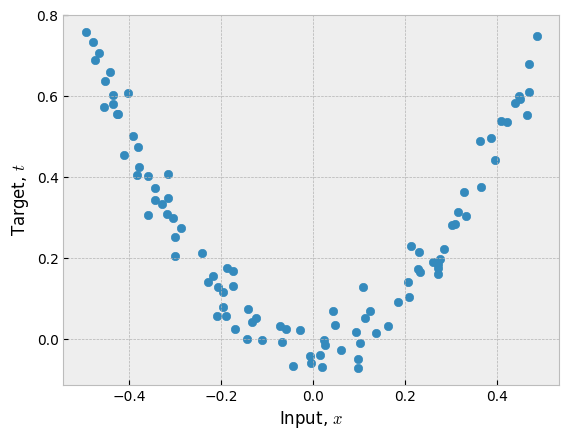

In [23]:
plt.scatter(X, t)
plt.xlabel('Input, $x$'); plt.ylabel('Target, $t$');

In [27]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg1 = DecisionTreeRegressor(max_depth=2) 
tree_reg1.fit(X, t)

DecisionTreeRegressor(max_depth=2)

In [28]:
print(tree_reg1.predict(X))

[0.12356613 0.52856846 0.12356613 0.12356613 0.12356613 0.12356613
 0.66091233 0.52856846 0.12356613 0.12356613 0.66091233 0.52856846
 0.52856846 0.12356613 0.12356613 0.12356613 0.12356613 0.12356613
 0.12356613 0.12356613 0.12356613 0.48779682 0.12356613 0.12356613
 0.12356613 0.12356613 0.12356613 0.12356613 0.12356613 0.66091233
 0.12356613 0.12356613 0.66091233 0.52856846 0.52856846 0.12356613
 0.12356613 0.48779682 0.12356613 0.12356613 0.48779682 0.12356613
 0.66091233 0.52856846 0.12356613 0.12356613 0.12356613 0.12356613
 0.12356613 0.12356613 0.52856846 0.12356613 0.52856846 0.52856846
 0.12356613 0.52856846 0.48779682 0.12356613 0.66091233 0.12356613
 0.12356613 0.12356613 0.52856846 0.12356613 0.12356613 0.12356613
 0.12356613 0.12356613 0.48779682 0.52856846 0.12356613 0.12356613
 0.66091233 0.12356613 0.12356613 0.12356613 0.12356613 0.48779682
 0.12356613 0.48779682 0.52856846 0.12356613 0.12356613 0.66091233
 0.12356613 0.12356613 0.12356613 0.12356613 0.52856846 0.1235

Next, we'll train a second ```DecisionTreeRegressor``` predictor on the residual errors made by the first predictor:

In [31]:
# new target is the residual from the previous predictor
t2 = t - tree_reg1.predict(X)

print(t2)

[-0.07199323  0.06591133  0.04248548 -0.19374408  0.22041981  0.24930881
 -0.00114735 -0.15222706 -0.13331807 -0.01877138  0.07437546  0.1503149
 -0.22350214  0.15034361  0.18499381  0.22556424 -0.04370548 -0.13811059
 -0.12927709 -0.06598606 -0.0712269  -0.08485003  0.00630109 -0.08171801
 -0.18854512  0.0993776   0.12988566 -0.16307213 -0.10600905 -0.0235881
  0.00544086  0.21082582 -0.08049446  0.07220392  0.02593255  0.16043495
 -0.00602728  0.12096847 -0.03135875 -0.09774359 -0.06096712 -0.18193024
  0.04661096  0.01165776  0.09054676 -0.08979502  0.05293175 -0.1924505
 -0.08767772  0.2839068   0.08343389  0.0752132   0.05589207 -0.08607633
 -0.17234608  0.0087933  -0.03289674  0.17739276 -0.08642889  0.04545908
 -0.12555055  0.01717459 -0.16368755 -0.12355051  0.03177594 -0.05274012
  0.18286595  0.15963461  0.06821878  0.22169935  0.03693798  0.08272777
  0.09870988  0.18983085  0.0173284   0.05108913  0.06319544  0.06812974
 -0.04881665 -0.08084465 -0.03974744 -0.05426719 -0.09

In [32]:
tree_reg2 = DecisionTreeRegressor(max_depth=2) 
tree_reg2.fit(X, t2) 

DecisionTreeRegressor(max_depth=2)

Then we train a third regressor on the residual errors made by the second predictor:

In [33]:
# new taregt is the residual of the predictor's residual
t3 = t2 - tree_reg2.predict(X)

print(t3)

[ 0.01840471  0.02599835  0.00257251 -0.10334615  0.06058178  0.08947079
 -0.00114735 -0.19214004 -0.04292013 -0.05868436  0.07437546  0.11040193
 -0.26341512 -0.00949442  0.02515578  0.06572621  0.04669245 -0.04771265
 -0.03887916  0.02441188  0.01917103 -0.08485003  0.09669902  0.00867992
 -0.09814719  0.05946462 -0.02995236 -0.0726742  -0.01561112 -0.0235881
  0.09583879  0.0509878  -0.08049446  0.03229094 -0.01398043  0.12052198
  0.08437066  0.12096847  0.05903919 -0.00734565 -0.06096712 -0.0915323
  0.04661096 -0.02825521 -0.06929126  0.00060292  0.14332968 -0.10205257
  0.00272022  0.12406878  0.04352092  0.03530023  0.01597909 -0.12598931
 -0.08194814 -0.03111968 -0.03289674  0.01755473 -0.08642889  0.13585701
 -0.03515262 -0.14266343 -0.20360053 -0.03315258 -0.12806208  0.03765781
  0.02302793  0.11972164  0.06821878  0.18178637 -0.00297499 -0.07711026
  0.09870988  0.14991787 -0.02258458  0.01117616  0.02328247  0.06812974
  0.04158128 -0.08084465 -0.07966042  0.03613074 -0.0

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees: 

In [34]:
tree_reg3 = DecisionTreeRegressor(max_depth=2) 
tree_reg3.fit(X, t3)

DecisionTreeRegressor(max_depth=2)

In [38]:
t4 = t3 - tree_reg3.predict(X)
print(t4)

[ 0.01136124  0.09452781 -0.00447096 -0.11038961  0.05353832  0.08242732
 -0.00819081 -0.12361058 -0.0499636  -0.06572783  0.06733199  0.
 -0.19488566 -0.01653788  0.01811232  0.05868275  0.03964899 -0.05475612
 -0.04592262  0.01736841  0.01212757 -0.09189349  0.08965556  0.00163646
 -0.10519065  0.05242115 -0.03699583 -0.07971766 -0.02265458 -0.03063157
  0.08879533  0.04394434 -0.08753793  0.1008204   0.05454903  0.11347851
  0.07732719  0.113925    0.05199572 -0.01438912 -0.06801059 -0.09857577
  0.03956749  0.04027425 -0.07633473 -0.00644055  0.13628622 -0.10909603
 -0.00432325  0.11702531  0.11205037  0.02825676  0.08450855 -0.05745985
 -0.08899161  0.03740978 -0.03994021  0.01051127 -0.09347235  0.12881354
 -0.04219608 -0.14970689 -0.13507107 -0.04019604 -0.13510555  0.03061435
  0.01598446  0.11267817  0.06117532  0.         -0.01001846 -0.08415372
  0.09166641  0.14287441 -0.02962804  0.00413269  0.016239    0.06108628
  0.03453782 -0.08788812 -0.01113096  0.02908727 -0.0139904

In [39]:
tree_reg4 = DecisionTreeRegressor(max_depth=2) 
tree_reg4.fit(X, t4)

DecisionTreeRegressor(max_depth=2)

In [40]:
X_new = np.array([[-0.3]]) #new input point

X_new

array([[-0.3]])

In [41]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3, tree_reg4))

y_pred

array([0.29044761])

The plot below represents the predictions of these three trees in the left column, and the ensemble's predictions in the right column. 

* In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree's predictions. 

* In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. 
* Similarly, in the third row another tree is trained on the residual errors of the second tree. 

You can see that the ensemble's predictions gradually get better as trees are added to the ensemble.

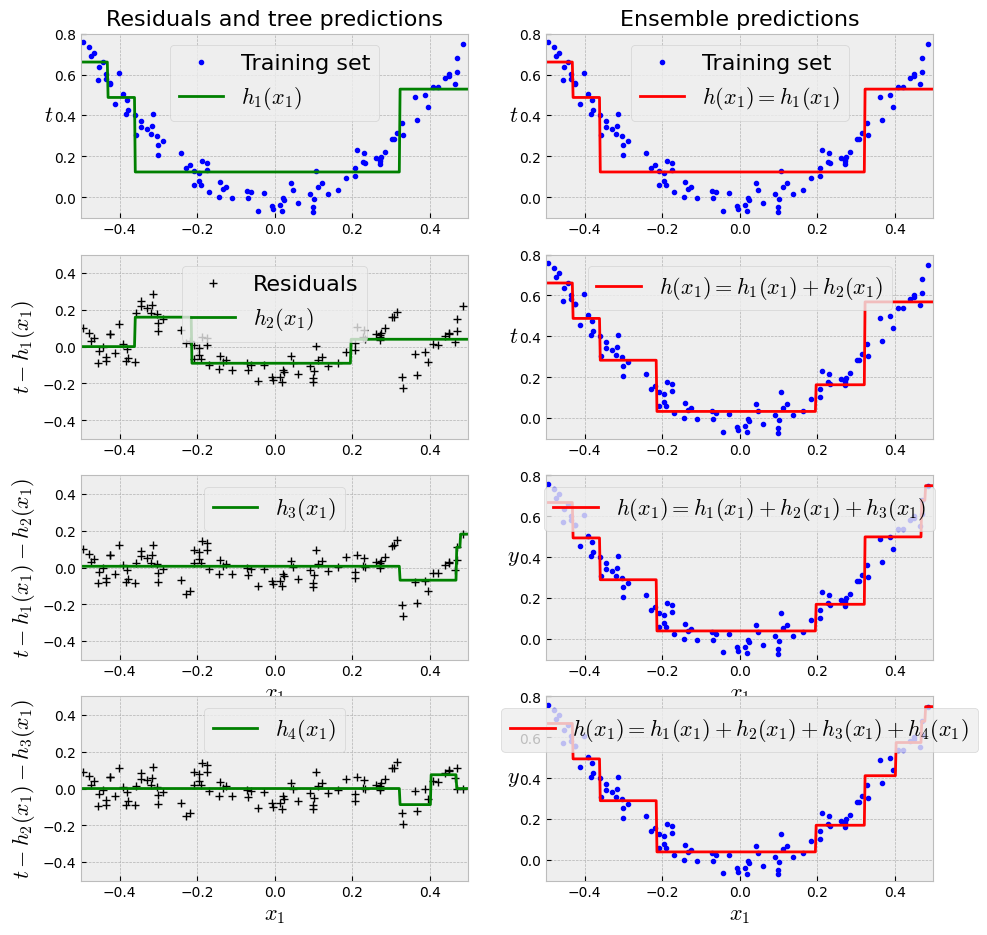

In [43]:
def plot_predictions(regressors, X, t, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], t, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,11))
plt.subplot(421)
plot_predictions([tree_reg1], X, t, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$t$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(422)
plot_predictions([tree_reg1], X, t, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$t$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(423)
plot_predictions([tree_reg2], X, t2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$t - h_1(x_1)$", fontsize=16)

plt.subplot(424)
plot_predictions([tree_reg1, tree_reg2], X, t, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$t$", fontsize=16, rotation=0)

plt.subplot(425)
plot_predictions([tree_reg3], X, t3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$t - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(426)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, t, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0);
# -------------------------------------t4-----------------------------
plt.subplot(427)
plot_predictions([tree_reg4], X, t4, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_4(x_1)$", style="g-", data_style="k+")
plt.ylabel("$t - h_2(x_1) - h_3(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(428)
plot_predictions([tree_reg1, tree_reg2, tree_reg3, tree_reg4], X, t, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)+ h_4(x_1) $")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0);

A simpler way to train GBRT ensembles is to use ```Scikit-Learn```'s ```GradientBoostingRegressor``` class. Much like the ```RandomForestRegressor``` class, it has hyperparameters to control the growth of Decision Trees (e.g., ```max_depth```, ```min_samples_leaf```), as well as hyperparameters to control the ensemble training, such as the number of trees (```n_estimators```). The following code creates the same ensemble as the previous one:

In [48]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# GradientBoostingRegressor?

# GradientBoostingClassifier?

In [54]:
gbrt = GradientBoostingRegressor(max_depth=2,
                                n_estimators=3,
                                learning_rate=1.0,
                                random_state=42)


gbrt

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [55]:
gbrt.fit(X, t)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The ```learning_rate``` hyperparameter scales the contribution of each tree. 

* If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. 

This is a regularization technique called **shrinkage**.

In [56]:
gbrt_slow = GradientBoostingRegressor(max_depth=2,
                                     n_estimators=50,
                                     learning_rate=0.1,
                                     random_state=42)

gbrt_slow.fit(X, t)

GradientBoostingRegressor(max_depth=2, n_estimators=50, random_state=42)

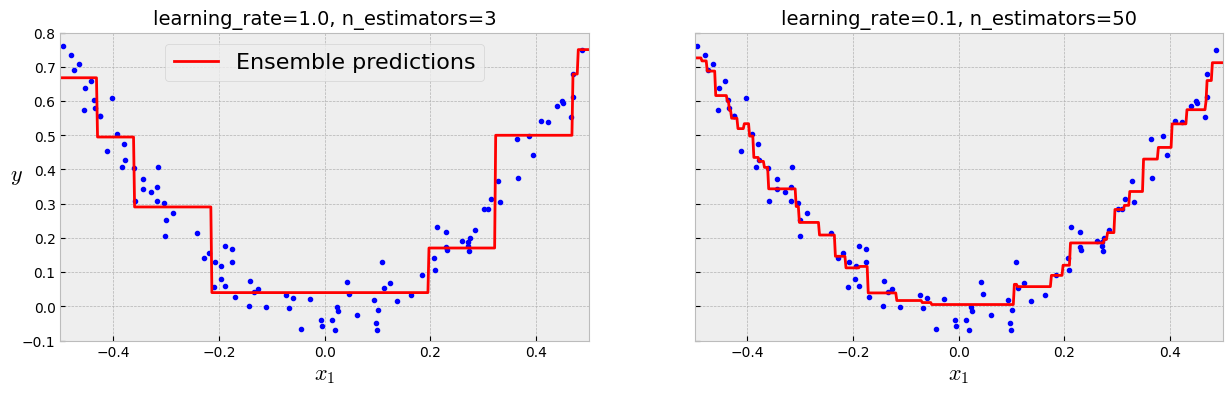

In [57]:
fix, axes = plt.subplots(ncols=2, figsize=(15,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, t, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, t, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16);

* The plot one on the left does not have enough trees to fit the training set (large ```learning_rate```) 

* The one on the right has too many trees and overfits the training set (small ```learning_rate```)

In order to find the optimal number of trees, you can use **early stopping**. 

A simple way to implement this is to use the ```staged_predict()``` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). 

The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [58]:
X

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394],
       [ 0.09865848],
       [-0.34398136],
       [-0.34400548],
       [-0.44191639],
       [ 0.36617615],
       [ 0.10111501],
       [ 0.20807258],
       [-0.47941551],
       [ 0.46990985],
       [ 0.33244264],
       [-0.28766089],
       [-0.31817503],
       [-0.31659549],
       [-0.19575776],
       [ 0.02475643],
       [-0.06805498],
       [-0.20877086],
       [ 0.11185289],
       [-0.36050614],
       [-0.20785535],
       [-0.13363816],
       [-0.04393002],
       [ 0.28517596],
       [-0.30032622],
       [ 0.01423444],
       [ 0.09241457],
       [-0.45354959],
       [ 0.10754485],
       [-0.32947588],
       [-0.43494841],
       [ 0.44888554],
       [ 0.46563203],
       [ 0.30839735],
       [-0.19538623],
       [-0.40232789],
       [ 0.18423303],
       [-0.05984751],
       [-0.37796177],
       [-0.00482309],
       [-0.46561148],
       [ 0.4093204 ],
       [-0.24122002],
       [ 0

In [59]:
t

array([ 5.15728987e-02,  5.94479790e-01,  1.66051606e-01, -7.01779562e-02,
        3.43985933e-01,  3.72874939e-01,  6.59764984e-01,  3.76341398e-01,
       -9.75194335e-03,  1.04794741e-01,  7.35287787e-01,  6.78883363e-01,
        3.05066318e-01,  2.73909733e-01,  3.08559932e-01,  3.49130363e-01,
        7.98606436e-02, -1.45444646e-02, -5.71096619e-03,  5.75800683e-02,
        5.23392240e-02,  4.02946793e-01,  1.29867214e-01,  4.18481141e-02,
       -6.49789982e-02,  2.22943721e-01,  2.53451786e-01, -3.95060058e-02,
        1.75570720e-02,  6.37324227e-01,  1.29006981e-01,  3.34391950e-01,
        5.80417870e-01,  6.00772381e-01,  5.54501010e-01,  2.84001079e-01,
        1.17538848e-01,  6.08765289e-01,  9.22073759e-02,  2.58225391e-02,
        4.26829699e-01, -5.83641153e-02,  7.07523289e-01,  5.40226226e-01,
        2.14112889e-01,  3.37711060e-02,  1.76497872e-01, -6.88843767e-02,
        3.58884053e-02,  4.07472924e-01,  6.12002352e-01,  1.98779325e-01,
        5.84460527e-01,  

In [62]:
## Gradient Boosting with Early Stopping

from sklearn.metrics import mean_squared_error

X_train, X_val, t_train, t_val = train_test_split(X, t, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [63]:
gbrt.fit(X_train, t_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [66]:
X_val

array([[ 0.27127035],
       [ 0.28517596],
       [ 0.09241457],
       [ 0.22900717],
       [ 0.12329813],
       [ 0.02006802],
       [-0.00482309],
       [-0.20785535],
       [-0.45354959],
       [ 0.45071431],
       [-0.35907578],
       [ 0.30219698],
       [-0.36050614],
       [-0.12545988],
       [-0.43644165],
       [-0.18828892],
       [ 0.21324479],
       [-0.13363816],
       [-0.42595535],
       [ 0.04269608],
       [ 0.27513282],
       [-0.4115075 ],
       [-0.28766089],
       [-0.39210857],
       [ 0.46958463]])

In [65]:
t_val

array([ 0.18676157,  0.22294372,  0.01755707,  0.17465526,  0.06929893,
       -0.06888438, -0.05836412,  0.12986721,  0.63732423,  0.59447979,
        0.30643207,  0.28320074,  0.40294679,  0.0515729 ,  0.60427162,
        0.17649787,  0.23125967,  0.04184811,  0.55592656,  0.070826  ,
        0.19877932,  0.45490008,  0.27390973,  0.50260656,  0.61200235])

In [67]:
y_pred

array([0.29044761])

In [ ]:
# This is the standard technique to detect overfitting in Gradient Boosting.

errors = [mean_squared_error(t_val, y_pred) 
          for y_pred in gbrt.staged_predict(X_val)]
errors

[0.03976434066090687,
 0.03301153878946109,
 0.027663386192027795,
 0.023337263188229852,
 0.020390590545872743,
 0.017820174421765502,
 0.015262814214454865,
 0.013228529533567415,
 0.011758450328306618,
 0.010288335529306629,
 0.009391268210618017,
 0.008605826199167754,
 0.007745553291052828,
 0.007083571270654957,
 0.006766296135021012,
 0.006116142333014483,
 0.005770219779341232,
 0.005416351332327169,
 0.0050727394710244665,
 0.0048159263120028765,
 0.004357591913537005,
 0.004192866645244622,
 0.0039670672414243964,
 0.0038463154458755833,
 0.0037468374981679863,
 0.003530909744387239,
 0.0034677533859285626,
 0.0033882676886440523,
 0.003224220772589744,
 0.0031883136637545035,
 0.003166151135979498,
 0.003072276914292378,
 0.003024919266015998,
 0.002991089248190895,
 0.002957301355498197,
 0.0028890741785044197,
 0.0028849656803361795,
 0.0028902935070124736,
 0.002836717946434534,
 0.0028151139950619727,
 0.002805906789900023,
 0.002769821491376303,
 0.002775136129921357,
 

In [71]:
bst_n_estimators = np.argmin(errors) + 1  #np.argmin → gives the index of the smallest value in an array
bst_n_estimators

56

In [72]:
gbrt_best = GradientBoostingRegressor(max_depth=2, 
                                      n_estimators=bst_n_estimators, 
                                      random_state=42)

gbrt_best.fit(X_train, t_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

The validation errors are represented on the left, and the best model's predictions are represented on the right.

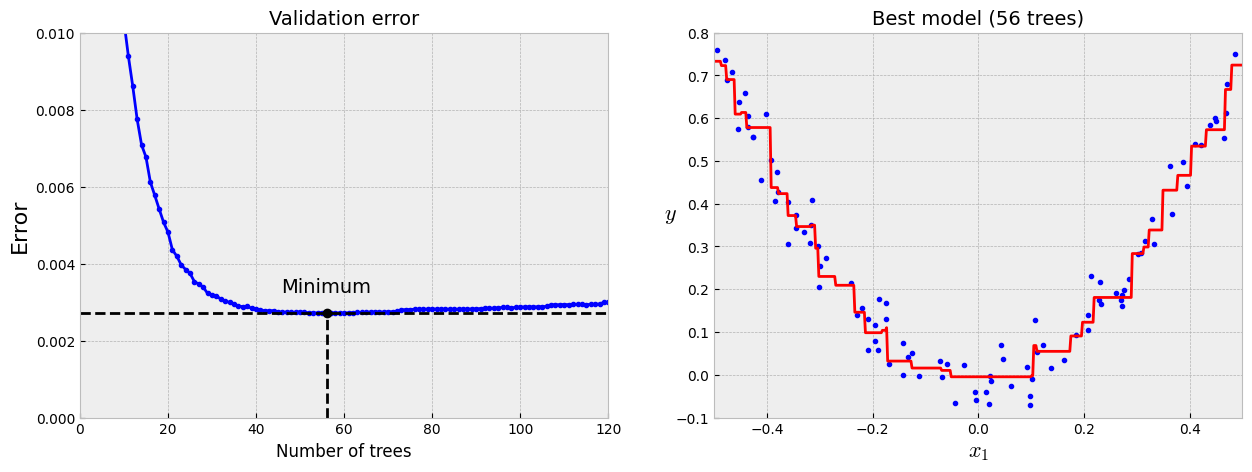

In [73]:
min_error = np.min(errors)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, t, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16);

Alternatively, you can tweak the hyperparameters ```validation_fraction```  - This tells Gradient Boosting to automatically hold out a part of the training data as a validation set (to detect overfitting).

or ```n_iter_no_change```: - This tells the model how many rounds (trees) to wait without improvement before stopping early.

In [74]:
gbrt = GradientBoostingRegressor(max_depth=2, 
                                      n_estimators=200,
                                      validation_fraction=0.1,
                                      n_iter_no_change=5,
                                      random_state=42)

gbrt.fit(X_train, t_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, n_iter_no_change=5,
                          random_state=42)

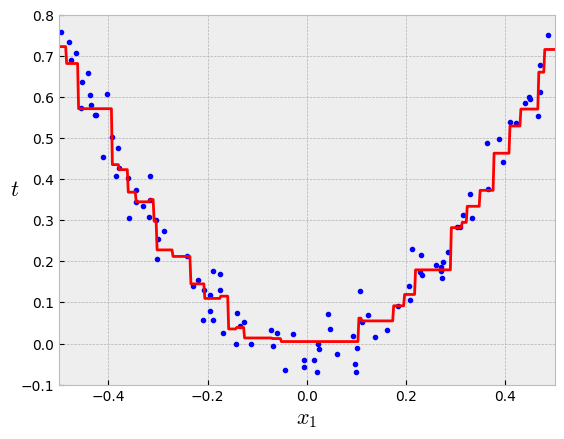

In [75]:
plot_predictions([gbrt], X, t, axes=[-0.5, 0.5, -0.1, 0.8])
plt.ylabel("$t$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16);

### Stochastic Gradient Boosting

The ```GradientBoostingRegressor``` class also supports a ```subsample``` hyperparameter, which specifies the fraction of training instances to be used for training each tree. 

* For example, if ```subsample=0.25```, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably.

This is called **Stochastic Gradient Boosting**.

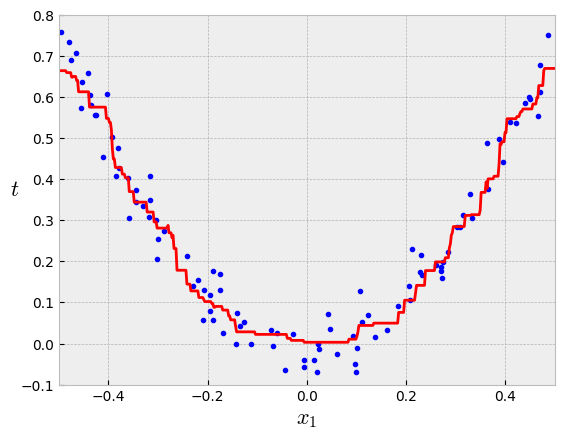

In [76]:
gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=200,
                                 validation_fraction=0.1,
                                 n_iter_no_change=5,
                                 subsample=0.25,
                                 random_state=42)

gbrt.fit(X_train, t_train)

plot_predictions([gbrt], X, t, axes=[-0.5, 0.5, -0.1, 0.8])
plt.ylabel("$t$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16);

---
---
---